In [1]:
import time
import pandas as pd
from kid_readout.analysis import archive
from equipment.vdi.zbd import ZBD
from equipment.srs.lockin import SR830
from kid_readout.equipment import hittite_controller
plt.rcParams['font.size'] = 11

/home/local/lib/python2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


updated file list


In [2]:
def zbd_peak_voltage(lockin_rms_voltage):
    return 2**(-1/2) * np.pi * lockin_rms_voltage

def lockin_rms_voltage(zbd_peak_voltage):
    return 2**(1/2) / np.pi * zbd_peak_voltage

def zbd_power(lockin_rms_voltage, optical_frequency=None):
    if optical_frequency is None:
        return zbd_peak_voltage(lockin_rms_voltage) / 2200
    else:
        return zbd_peak_voltage(lockin_rms_voltage) / ZBD().responsivity(optical_frequency)

def acquire(df, lockin, mickey, minnie):
    lockin.auto_gain()
    time_constant = lockin.time_constant_integer_to_seconds[lockin.time_constant]
    time.sleep(5 * time_constant)
    return df.append({'time': time.time(),
                      'mickey': mickey,
                      'minnie': minnie,
                      'R': lockin.R,
                      'time_constant': time_constant},
             ignore_index=True)
    return df

In [14]:
lockin = SR830('/dev/ttyUSB2')
zbd = ZBD()
hittite = hittite_controller.hittiteController()

In [4]:
frequency = 156e9
coherent156 = archive.load_archive('/data/readout/archive/2015-05-20_mmw_156_GHz.npy')
coherent156.zbd_power.max()

6.8471430471939645e-05

In [15]:
hittite.set_power(0)
hittite.set_freq(frequency / 12)
hittite.on()

# Overnight stability test

In [16]:
# The power at 5, 5 turns is about 9 uW, near the upper end of the linear region.

stability_filename = '/home/flanigan/notebooks/equipment/source_overnight_stability_156_GHz_5_5_turns.npy'
# stability = pd.DataFrame(columns=('time', 'mickey', 'minnie', 'R', 'time_constant'))
#while True:
#    stability = acquire(stability, lockin, 5, 5)
#    time.sleep(10*60)
#np.save('/home/flanigan/notebooks/equipment/source_overnight_stability_156_GHz_5_5_turns.npy',
#        stability.to_records())
stability = pd.DataFrame().from_records(np.load(stability_filename))

In [17]:
stability_tempco_filename = '/home/flanigan/notebooks/equipment/source_overnight_stability_156_GHz_5_5_turns_tempco.npy'
#stability_tempco = pd.DataFrame(columns=('time', 'mickey', 'minnie', 'R', 'time_constant'))
#while True:
#    stability_tempco = acquire(stability_tempco, lockin, 5, 5)
#    time.sleep(10*60)
#np.save(stability_tempco_filename, stability_tempco.to_records())
stability_tempco = pd.DataFrame().from_records(np.load(stability_tempco_filename))

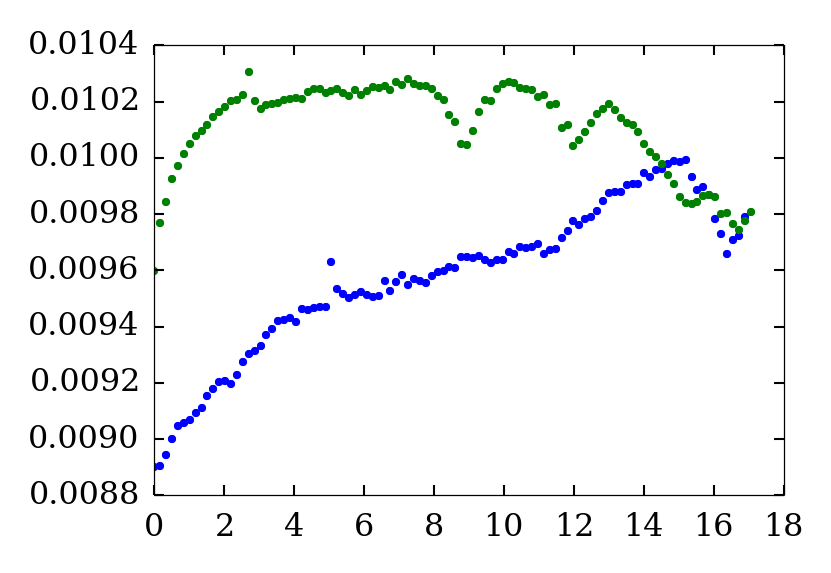

In [18]:
plt.plot((stability.time - stability.time.iloc[0]) / 3600, stability.R, '.')
plt.plot((stability_tempco.time - stability_tempco.time.iloc[0]) / 3600, stability_tempco.R, '.')

# Data

These settings more or less bracket the nominal linear region of 1 to 10 $\mu$W:

In [19]:
# 5, 5 turns:
zbd_power(9.44e-3, optical_frequency=frequency)

9.18130506735175e-06

In [20]:
# 6, 6 turns:
zbd_power(1.57e-3, optical_frequency=frequency)

1.5269755249726955e-06

Note that there is detectable backlash when the forward distance is less than two turns; in one test, using one turn produced 4% difference in power. Earlier data may be contaminated by this, since I was using more like a quarter turn before. See /home/flanigan/equipment/vdi/calibration_156_GHz_backlash.npy

Use 6, 6 turns as the witness setting.

In [21]:
df_filename = '/home/flanigan/equipment/vdi/calibration_156_GHz.npy'

In [32]:
#df = pd.DataFrame(columns=('time', 'mickey', 'minnie', 'R', 'time_constant'))
df = pd.DataFrame().from_records(np.load(df_filename), index='index')

Take a point and plot the existing data

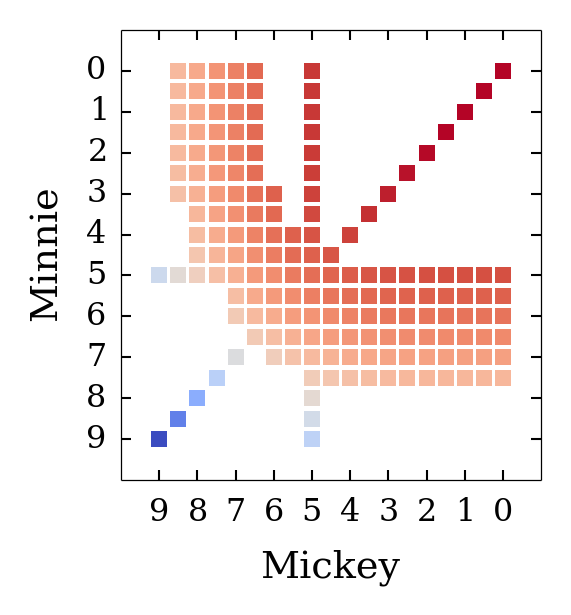

In [187]:
mickey = 6
minnie = 6
df = acquire(df, lockin, mickey, minnie)
np.save(df_filename, df.to_records())
fig, ax = plt.subplots(figsize=(2, 2))
norm = matplotlib.colors.LogNorm
mappable = plt.cm.ScalarMappable(norm(min(df.R), max(df.R)), cmap=plt.cm.coolwarm)
mappable.set_array(np.array(df.R))
for n, row in df.iterrows():
    ax.plot(row.mickey, row.minnie, color=mappable.to_rgba(row.R),
            marker='s', markersize=4, markeredgecolor='none')
ax.set_xlim(10, -1)
ax.set_xticks(range(9, -1, -1))
ax.set_ylim(10, -1)
ax.set_yticks(range(9, -1, -1))
ax.set_xlabel('Mickey')
ax.set_ylabel('Minnie');

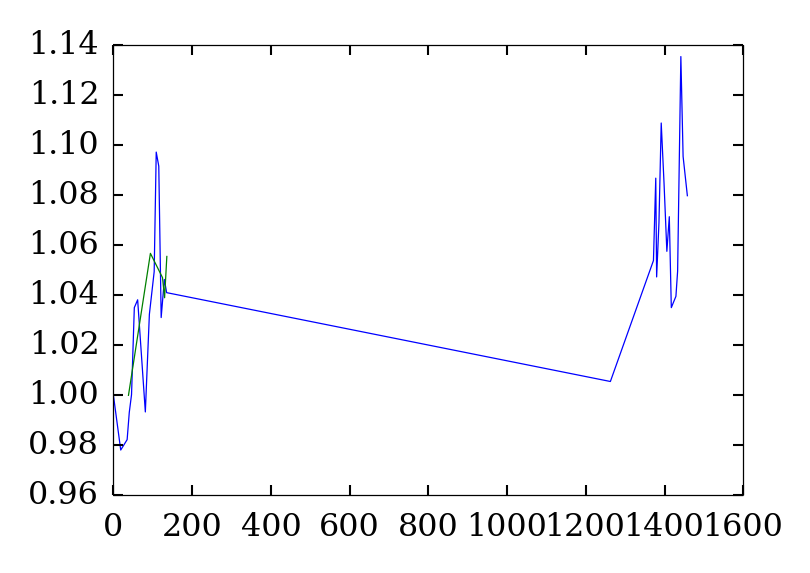

In [188]:
mask6 = (df.mickey==6) & (df.minnie==6)
mask5 = (df.mickey==5) & (df.minnie==5)
plt.plot((df[mask6].time - df.time.min()) / 60, df[mask6].R / df[mask6].R.iloc[0], '-')
plt.plot((df[mask5].time - df.time.min()) / 60, df[mask5].R / df[mask5].R.iloc[0], '-')

# Fast

Take a few points in the nominally linear region to test linearity.

In [190]:
fast = pd.DataFrame(columns=('time', 'mickey', 'minnie', 'R', 'time_constant'))

In [191]:
fast = acquire(fast, lockin, 6, 6)

In [192]:
fast = acquire(fast, lockin, 6, 5)

In [193]:
fast = acquire(fast, lockin, 5, 5)

In [194]:
fast = acquire(fast, lockin, 5, 6)

In [196]:
(fast.iloc[0].R * fast.iloc[2].R) / (fast.iloc[1].R * fast.iloc[3].R)

0.95888338692455422